# Movie Recommendations

### Import Labraries

In [30]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/home/hooshmand/Documents/Git/myenv/lib/python3.11/site-packages')
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime

now = datetime.now()

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error


import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy


### Load Data

In [2]:
rating_data = pd.read_csv('data/rating.csv')
movie_data = pd.read_csv('data/movie.csv')

In [3]:
rating_data.shape


(20000263, 4)

In [4]:
rating_data.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


### Convert fields into appropriate data types

In [5]:
rating_data.userId = rating_data.userId.astype(str).astype(int)
rating_data.movieId = rating_data.movieId.astype(str).astype(int)
rating_data.rating = rating_data.rating.astype(str).astype(float)
rating_data.timestamp = rating_data.timestamp.apply(lambda x: now.strftime("%m/%d/%Y, %H:%M:%S"))

In [6]:
n_users = rating_data.userId.unique().shape[0]
n_movies = rating_data.movieId.unique().shape[0]
max_rate = rating_data.rating.max()
min_rate = rating_data.rating.min()
n_rates_firstMovie = rating_data.movieId[rating_data.movieId==1].groupby(rating_data.rating).count()
mean_rates_firstMovie = rating_data.rating[rating_data.movieId==1].mean()

In [7]:
print('Number of users: ', n_users)
print('Number of movies: ', n_movies)
print('Max of ratings: ', max_rate, ', and Min of ratings: ', min_rate)
print('Rating details for the first movie: \n', n_rates_firstMovie)
print('Average number of ratings for the first movie: ', mean_rates_firstMovie)

Number of users:  138493
Number of movies:  26744
Max of ratings:  5.0 , and Min of ratings:  0.5
Rating details for the first movie: 
 rating
0.5      178
1.0      506
1.5      266
2.0     1440
2.5     1060
3.0     8751
3.5     4200
4.0    17136
4.5     3890
5.0    12268
Name: movieId, dtype: int64
Average number of ratings for the first movie:  3.921239561324077


### Reduce size of Data

In [8]:
movieIndex = rating_data.groupby("movieId").count().sort_values(by= "rating",ascending=False)[0:1000].index
new_rating_data = rating_data[rating_data.movieId.isin(movieIndex)]
new_rating_data

,userId,movieId,rating,timestamp
0,1,2,3.5,"07/28/2024, 12:54:16"
1,1,29,3.5,"07/28/2024, 12:54:16"
2,1,32,3.5,"07/28/2024, 12:54:16"
3,1,47,3.5,"07/28/2024, 12:54:16"
4,1,50,3.5,"07/28/2024, 12:54:16"
...,...,...,...,...
20000243,138493,53996,4.5,"07/28/2024, 12:54:16"
20000249,138493,59315,4.0,"07/28/2024, 12:54:16"
20000252,138493,60069,4.0,"07/28/2024, 12:54:16"
20000258,138493,68954,4.5,"07/28/2024, 12:54:16"


### Data Visualization

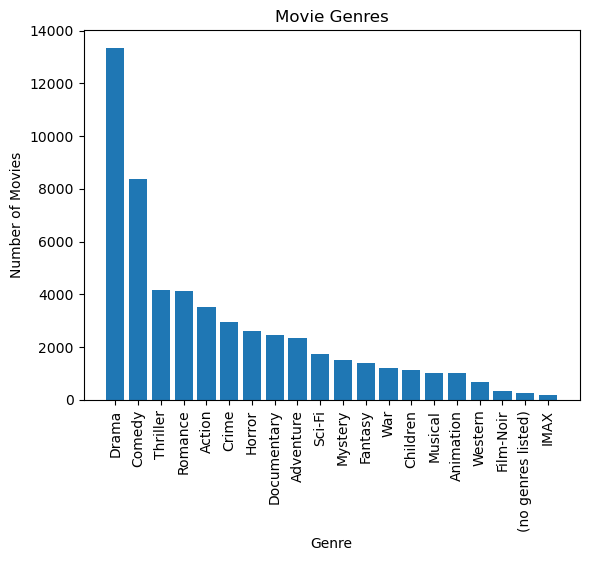

In [9]:
genres = movie_data.genres.str.split('|', expand=True).stack().value_counts()
plt.bar(genres.index, genres.values)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movie Genres')
plt.show()

In [14]:
mean_rates = new_rating_data.rating[new_rating_data.rating >= 4.5].groupby(new_rating_data.movieId).mean()
    
mean_rates

movieId
1        4.879626
2        4.893195
3        4.952549
5        4.952012
6        4.871508
           ...   
78499    4.744267
79132    4.758475
80463    4.680777
81591    4.706482
81845    4.694953
Name: rating, Length: 1000, dtype: float64

In [26]:
lager = mean_rates.nlargest(20)   
lager

movieId
140    4.984375
276    4.982270
79     4.974614
494    4.972680
204    4.972408
225    4.970446
237    4.969979
222    4.966709
786    4.965917
280    4.962038
185    4.956325
95     4.954463
317    4.953464
339    4.953350
788    4.952988
160    4.952690
3      4.952549
207    4.952494
800    4.952070
5      4.952012
Name: rating, dtype: float64

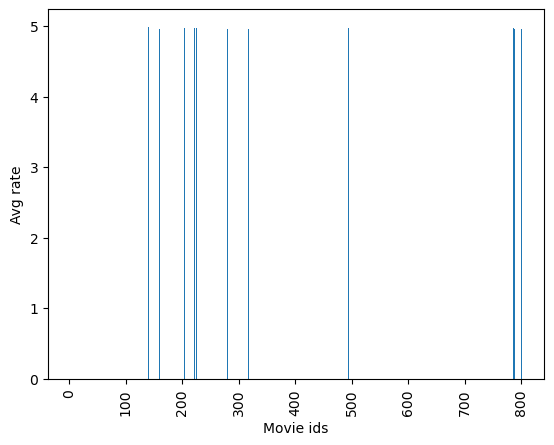

In [27]:
plt.bar(lager.index, lager.values)
plt.xticks(rotation=90)
plt.xlabel('Movie ids')
plt.ylabel('Avg rate')
plt.show()

### Spliting Dataset

In [31]:
X_train, X_test = train_test_split(new_rating_data,test_size=0.10, shuffle=True, random_state=2018)
X_validation, X_test = train_test_split(X_test,test_size=0.50, shuffle=True, random_state=2018)

In [32]:
print('Shape of train set:', X_train.shape)
print('Shape of validation set:',X_validation.shape)
print('Shape of test set: ',X_test.shape)

Shape of train set: (11556309, 4)
Shape of validation set: (642017, 4)
Shape of test set:  (642018, 4)
